### [SMA Strategy](https://pmorissette.github.io/bt/examples.html#:~:text=is%20all%20about.-,SMA%20Strategy,-Let%E2%80%99s%20start%20off) (Simple Moving Average)

- 현재 가격이 50일 이동 평균선보다 높은 종목을 선택한다.
- 종목의 가중치는 균등하게 매수한다.
- 가중치를 반영하여 리벨런싱을 수행한다.

In [1]:
import bt
import pandas as pd

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline

In [2]:
# 데이터 다운로드
data: pd.DataFrame = bt.get("aapl,msft,c,gs,ge", start="2020-01-01")

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


테스트가 진행되는 동안 평균을 계산할 수 도 있겠지만 비효율적이므로 처음부터 평균을 계산해둔다.

In [3]:
# 50일 이동평균선
sma = data.rolling(50).mean()

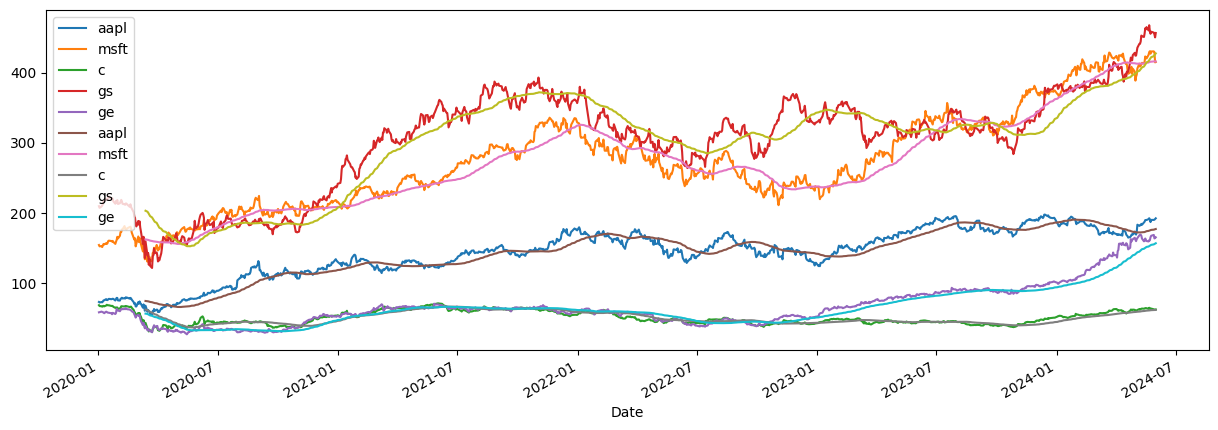

In [4]:
# 시각화
plot = bt.merge(data, sma).plot(figsize=(15, 5))

50일 이동평균 선보다 가격이 높은 주식을 선택하는 알고리즘을 만들어본다.

In [5]:
from typing import List

from bt.algos import Rebalance, RunOnce, SelectAll, WeighEqually
from bt.backtest import Backtest, Result
from bt.core import Algo, Strategy


class SelectWhere(Algo):

    def __init__(self, signal: pd.DataFrame):
        self.signal = signal

    def __call__(self, target: Strategy):
        if target.now in self.signal.index:
            sig: pd.Series = self.signal.loc[target.now]

            selected: List[str] = list(sig.index[sig]) # ex) ['aapl', 'msft', 'gs']

            target.temp["selected"] = selected

        # return True because we want to keep on moving down the stack
        return True

In [6]:
# 50일 이동평균선 보다 높은 신호
signal: pd.DataFrame = data > sma
signal.head()

,aapl,msft,c,gs,ge
Date,,,,,
2020-01-02,False,False,False,False,False
2020-01-03,False,False,False,False,False
2020-01-06,False,False,False,False,False
2020-01-07,False,False,False,False,False
2020-01-08,False,False,False,False,False


In [7]:
# 전략 생성
strategy = Strategy("Above 50 sma", algos=[SelectWhere(signal), WeighEqually(), Rebalance()])

backtest = Backtest(strategy, data)

result: Result = bt.run(backtest)

<Axes: title={'center': 'Equity Progression'}>

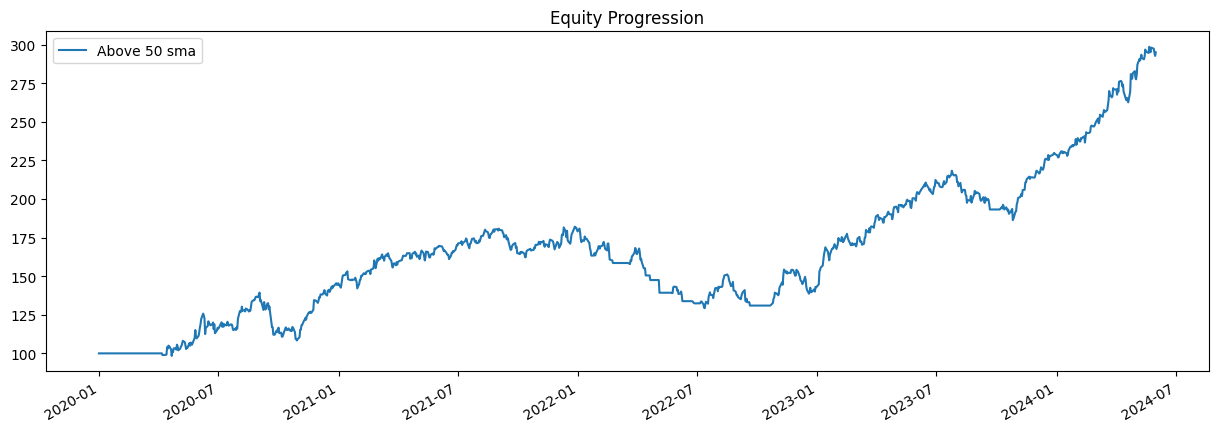

In [8]:
result.plot()

알고리즘이 시장을 이기는지? 확인해보자
- 2022년 중반부터 시장을 이기는 sma10
- 2023년 중반부터 시장을 이기는 sma20
- 최근에 aapl,msft,c,gs,ge 종목들이 syp를 상회하는 듯하다.

In [9]:
def above_sma(tickers, sma_per=50, start="2010-01-01", name="above_sma") -> Backtest:
    data: pd.DataFrame = bt.get(tickers, start=start)
    sma = data.rolling(sma_per).mean()
    s = Strategy(name, [SelectWhere(data > sma), WeighEqually(), Rebalance()])
    return Backtest(s, data)

In [10]:
def long_only_ew(tickers, start="2010-01-01", name="long_only_ew") -> Backtest:
    s = Strategy(
        name, [RunOnce(), SelectAll(), WeighEqually(), Rebalance()]  # buy and hold strategy
    )
    data = bt.get(tickers, start=start)
    return Backtest(s, data)

In [11]:
tickers = "aapl,msft,c,gs,ge"
sma10 = above_sma(tickers, sma_per=10, name="sma10")
sma20 = above_sma(tickers, sma_per=20, name="sma20")
sma40 = above_sma(tickers, sma_per=40, name="sma40")
sma50 = above_sma(tickers, sma_per=50, name="sma50")
benchmark = long_only_ew("spy", name="benchmark-spy")
res2: Result = bt.run(sma10, sma20, sma40, sma50, benchmark)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<Axes: title={'center': 'daily Equity Progression'}>

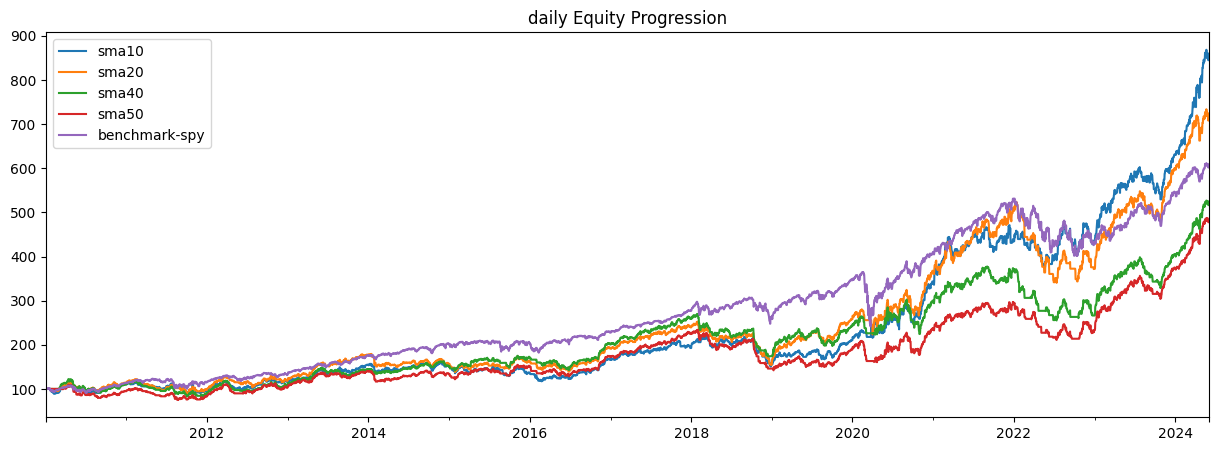

In [12]:
res2.plot(freq='d')